## Семинар 2 "Распознавание рукописных цифр"

ФИО: Филимонов Степан Владиславович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [7]:
!pip install torch torchvision

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import platform
import sys

from platform import python_version

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [15]:
print(f'Версия Python {platform.python_version()}')
print(f'Моя платформа {platform.platform()}')
print(f'Версия библиотеки PyTorch {torch.__version__}')
print(f'Могули я использовать CUDA? {torch.cuda.is_available()}')

Версия Python 3.11.9
Моя платформа macOS-14.6.1-arm64-arm-64bit
Версия библиотеки PyTorch 2.4.1
Могули я использовать CUDA? False


#### Код взятый из предыдущего задания

In [23]:
import pandas as pd
from tqdm import tqdm
import progressbar

In [24]:
class Activation:
    def __init__(self, codeActivation: str = 'sigmoid', alpha: float = 0.0):
        '''
        Источник: https://habr.com/ru/articles/727506/
        '''
        assert (alpha >= 0.0), f'Альфа меньше 0: {alpha}'
        assert (codeActivation in ['relu', 'leakedrelu', 'sigmoid', 'linear']), f'''
            Не корректная функция: {codeActivation}'''

        self._alpha = alpha
        self._codeActivation = codeActivation

    def _sigmoid(self, x: np.ndarray):
        return 1.0 / (1.0 + np.exp(-x))

    def __call__(self, x: np.ndarray):
        if self._codeActivation == 'relu' or self._codeActivation == 'leakedrelu':
            return np.where(x > 0.0, x, self._alpha * x)
        elif self._codeActivation == 'sigmoid':
            return self._sigmoid(x)
        elif self._codeActivation == 'linear':
            return x

    def derivative(self, x: np.ndarray):
        if self._codeActivation == 'relu' or self._codeActivation == 'leakedrelu':
            return np.where(x > 0.0, 1.0, self._alpha)
        elif self._codeActivation == 'sigmoid':
            return self._sigmoid(x) * (1 - self._sigmoid(x)) 
        elif self._codeActivation == 'linear':
            return 1

In [25]:
class Layer:
    '''
    Класс для описания слоя нейронной сети
    Атрибуты
    --------
    public:
        biases : np.ndarray
            Предупреждения
        db : np.ndarray
            Диференциал предупреждения
        weights : np.ndarray
            Веса
        dw : np.ndarray
            Диференциал весов
    private:
        _learning_rate : float
            Скорость обучения
        _activation : Activation
            Активатор
        _count : int
            Подсчет прохода
        _input : np.ndarray
            Входные нейроны
    Методы
    ------
        forward - прямой проход ~~Как я понимаю, это стандартное название~~
            inp - input - входные значения
        backward - обратный проход
            error - ошибка по который калибровать
            prev_out - Предыдущие значения
        __call__ - обновление весов
    '''
    def __init__(self, prev_size: int, size: int, learning_rate: float, activation: Activation):
        self._learning_rate = learning_rate
        self._activation = activation
        self._count = 0

        self.biases = np.random.rand(size).reshape(-1, 1) / 10.0
        self.db = np.zeros_like(self.biases)

        if prev_size is not None and prev_size != 0:
            self.weights = np.random.rand(size, prev_size) / 10.0
            self.dw = np.zeros_like(self.weights)

    def forward(self, inp: np.ndarray):
        self._input = (self.weights * inp + self.biases) if inp.ndim == 0 \
            else (self.weights @ inp + self.biases)
        return self._activation(self._input)

    def backward(self, error: np.ndarray, prev_out: np.ndarray):
        self._count += 1
        neurons = (error.reshape(-1, 1) * self._activation.derivative(self._input)).reshape(-1)

        self.dw += np.outer(neurons, prev_out)
        self.db += neurons.reshape(-1, 1)
        return (self.weights.T @ neurons)

    def __call__(self):
        '''
        Обновление весов,
        м-д сделал функтором, так как метод для прямого и обратного прохода очевидны,
        и остается только обновление весов
        '''
        self.weights -= self._learning_rate * self.dw / self._count
        self.biases -= self._learning_rate * self.db / self._count

        self.dw = np.zeros_like(self.dw)
        self.db = np.zeros_like(self.db)
        self._count = 0

In [26]:
class MLPRegressor:
    '''
    Multi-Layer Perceptron Regressor    
    Атрибуты
    --------
    public:
        Нету
    private:
        _outputs : np.ndarray
            Выходные слои
        _x/y_mean : float
            Среднее значение по x и y
    Методы
    ------
    В некоторые методы вставлял проверки
    
    private:
        _loss - Квадратичная функция ошибки
        _lossDerivative - Произоводная _loss
        _forward - Прямой проход
        _backward - Обратный проход
        _updateWeights - обновление весов
        _initKnowingSizes - инициализация весов
        _forward_backward - метод прямого и обратного прохода
        _mean - усредненное значение
    public:
        train ~ fit
        predict
    '''
    
    def __init__(
        self,
        hidden_layer_sizes: tuple = (100,),           # Колличество нейронов/слоев
        activation: tuple = (Activation('sigmoid'),), # *функция активации*
        learning_rate: float = 0.001,                 # Скорость обучения
        max_iter: int = 200,                          # Максимальное колличество итерация
        batch: int = 10                               # Размер мини-пакетов, для обновления весов
    ):
        '''
        Сделал так, что можно для каждого слоя задать собственную функцию 
        перехода, либо что одна для всех будет. Читал, что в
        зависимости от слоя разные стоит применять.
        '''
        for a in activation:
            assert (type(a) == type(Activation())), f'Некорректный тип введен: {type(a)}'
        assert (len(activation) == len(hidden_layer_sizes) or len(activation) == 1), f'''
            Ошибка длины: {len(activation)} != {len(hidden_layer_sizes)} or {len(activation)} != 1'''

        self._learning_rate = learning_rate # Скорость обучения
        self._max_iter = max_iter           # Максимальное колличество итерация
        self._batch = batch                 # Размер мини-пакетов, для обновления весов
        self._layers = []                   # Слои
        self._input_size = None             # Входной размер
        self._output_size = None            # Выходной размер

        self._layers.append( Layer(None, hidden_layer_sizes[0], learning_rate, activation[0]) )
        if len(hidden_layer_sizes) == 1:
            return
        
        if len(activation) == 1:  # Если у нас 1 единый активатор
            for prev_size, curr_size in zip(hidden_layer_sizes, hidden_layer_sizes[1:]):
                self._layers.append(Layer(prev_size, curr_size, learning_rate, activation[0]))
        else: # Если на каждый слой есть активатор
            i = 1
            for prev_size, curr_size in zip(hidden_layer_sizes, hidden_layer_sizes[1:]):
                self._layers.append(Layer(prev_size, curr_size, learning_rate, activation[i]))
                i += 1

    def _loss(self, actual, predicted):
        '''
        Квадратичная функция ошибки
        '''
        return (actual - predicted) ** 2
    
    def _lossDerivative(self, actual, predicted):
        '''
        Производная квадратичная функция ошибки
        '''
        return -2 * (actual - predicted)
    
    def _forward(self, inp: np.ndarray, train: bool = False):
        assert inp.ndim == 1 or inp.ndim == 0, f'Измерения должны быть 1 or 0, ndim = {inp.ndim}'
        last_layer = inp.reshape(-1, 1)
        self._outputs = [inp] if train else self._outputs
        for layer in self._layers:
            last_layer = layer.forward(last_layer)
            if train:
                self._outputs.append(last_layer)
        return last_layer.reshape(-1)

    def _backward(self, actual, predicted):
        error = self._lossDerivative(actual, predicted)
        for i in range(len(self._layers) - 1, -1, -1): # Обратный проход
            error = self._layers[i].backward(error, self._outputs[i])

    def _updateWeights(self):
        '''
        Обновление весов в слоях
        '''
        for i in range(len(self._layers) - 1, -1, -1):
            self._layers[i]()

    def _mean(self, x, y):
        '''
        Нормализация значений, создаем копию еще, чтобы исходные
        данные не повредить, был баг почему то с этим. . .
        '''
        self._x_mean = x.mean()
        _x = (x / self._x_mean).copy()
        self._y_mean = y.mean()
        _y = (y / self._y_mean).copy()
        return _x, _y

    def _initKnowingSizes(self, x, y):
        '''
        Инициализация 
        '''
        self._input_size = 1 if x.ndim == 1 else x.shape[1]
        self._layers[0].weights = (np.random.rand(self._layers[0].biases.size, self._input_size) / 10)
        self._layers[0].dw = np.zeros_like(self._layers[0].weights)

        self._output_size = 1 if y.ndim == 1 else y.shape[1]
        self._layers.append(Layer(self._layers[-1].biases.size, self._output_size,
                                  self._learning_rate, Activation('linear')))

    def _forward_backward(self, _x, _y):
        '''
        Метод объединяющий метод прямого прохода и метод обратного прохода
        '''
        losses = []
        for _ in tqdm(range(self._max_iter)):
            i = 0
            losses_buf = []
            for inp, actual in zip(_x, _y):
                i += 1
                predicted = self._forward(inp, True)
                self._backward(actual, predicted)
                losses_buf.append(self._loss(actual, predicted) * self._y_mean)
                if i % self._batch == 0:
                    self._updateWeights()
                if i % int(_x.shape[0] / 10) == 1:
                    losses.append(sum(losses_buf) / len(losses_buf))
                    losses_buf = []
    
    def train(self, x: np.ndarray, y: np.ndarray):
        if self._input_size is not None:
            assert (self._input_size == (1 if x.ndim == 1 else x.shape[-1])), """
                Входное значение другое от предыдущего значения!"""
            assert (self._output_size == (1 if y.ndim == 1 else y.shape[-1])), """
                Выходное значение другое от предыдущего значения!"""
        else:
            self._initKnowingSizes(x, y)
        _x, _y = self._mean(x, y)
        self._forward_backward(_x, _y)
        

    def predict(self, x: np.ndarray):
        assert self._input_size is not None, 'Обучения не было'
        assert (self._input_size == (1 if x.ndim == 1 else x.shape[-1])), f'''
            Размер входных отличается от ожидаемых {self._input_size}'''
        
        # Нормализация значений, создаем копию еще, чтобы исходные
        # данные не повредить, был баг почему то с этим. . .
        _x = (x / self._x_mean).copy()
        return np.array([self._forward(inp) for inp in _x] if x.ndim == 2 or (x.ndim == 1 \
            and self._input_size == 1) else self._forward(_x)) * self._y_mean

#### Код который был

In [17]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

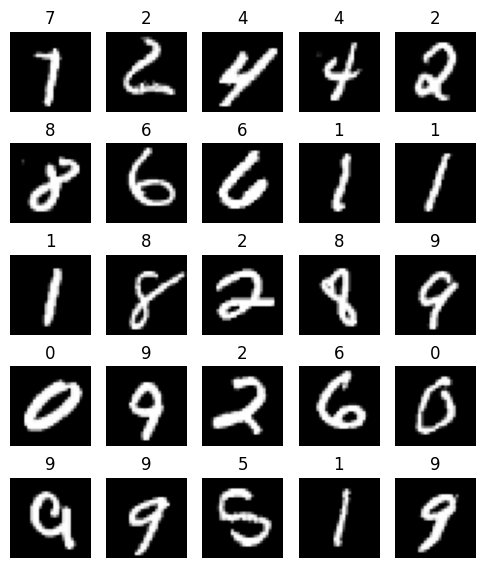

In [19]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [20]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [21]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.310/0.305	Accuracy: 0.919/0.919

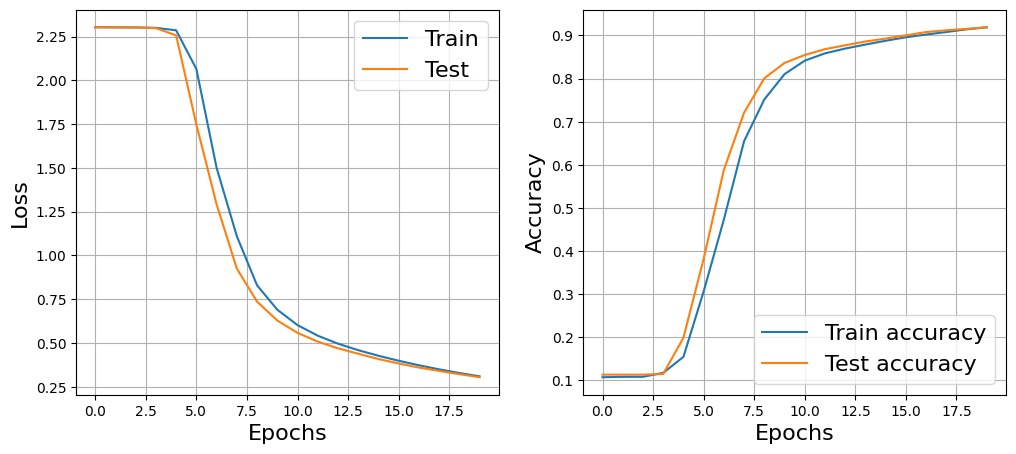

In [22]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [10]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [57]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [14]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.037/0.082	Accuracy: 0.990/0.976

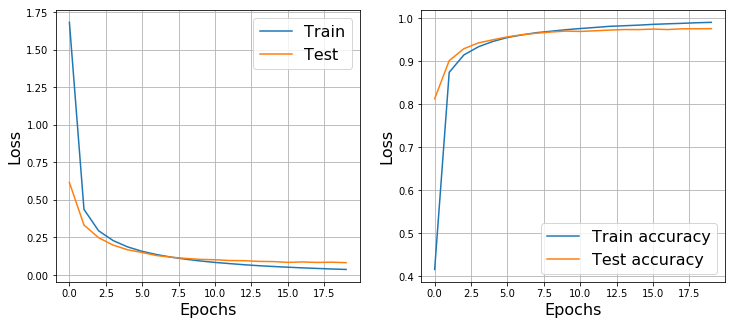

In [13]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.046/0.079	Accuracy: 0.987/0.976

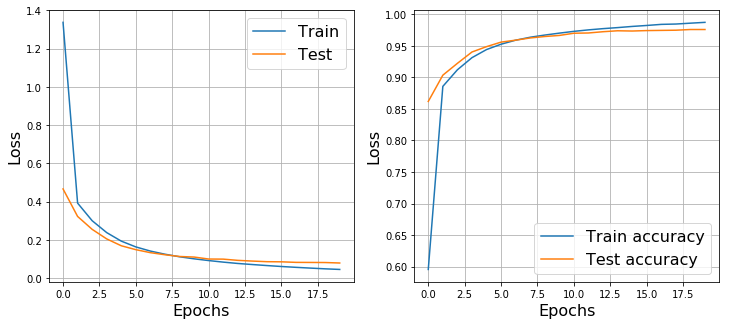

In [15]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

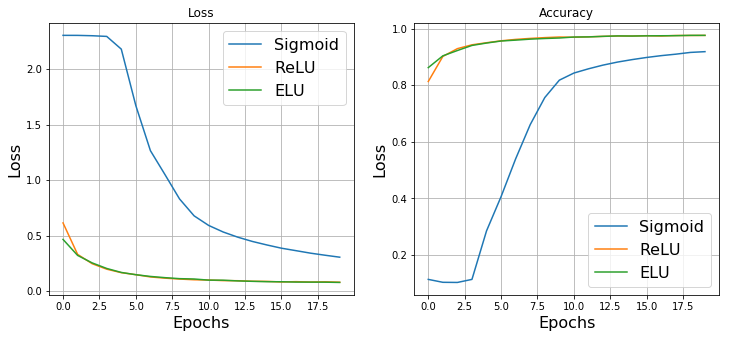

In [16]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

### Часть 3: Анализ ошибок

In [17]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

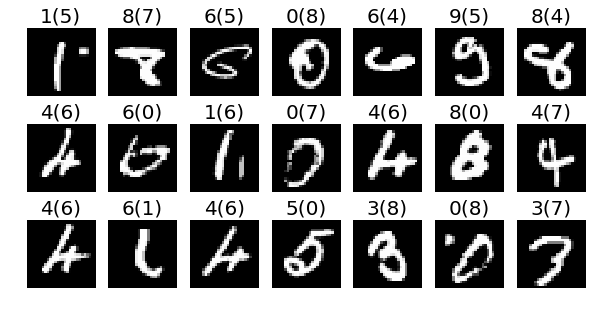

In [18]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [74]:
from skimage.transform import rotate

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?